# fitting to non-linear function

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def _fitness(x):
    if x > -11 and x < 11:
        y = (x**2 + x)*np.cos(2*x) + x**2
        return round(y, 6)
    else:
        return 0
    
fitness = np.vectorize(_fitness)

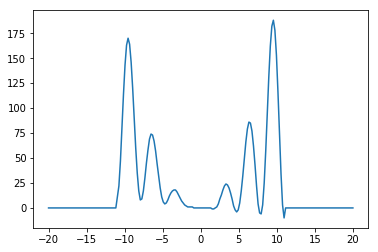

In [17]:
x = np.linspace(start=-20, stop=20, num=200)
plt.plot(x, fitness(x))

In [54]:
def _get_fittest_parent(parents, fitness):
    _fitness = fitness(parents)
    PFitness = list(zip(parents, _fitness))
    PFitness.sort(key = lambda x: x[1], reverse=True)
    best_parent, best_fitness = PFitness[0]
    return round(best_parent, 4), round(best_fitness, 4)

def mutation(parents, fitness_func):
    n = len(parents)
    scores = fitness_func(parents)
    idx = scores > 0
    scores = scores[idx]
    parents = np.array(parents)[idx]
    children = np.random.choice(parents, size=n, p=scores/scores.sum()) 
    children = children + np.random.uniform(-0.51, 0.51, size=n)
    return children.tolist()

In [71]:
def GA(parents, fitness_func, popsize=100, max_iter=100):
    history=[]
    best_parents, best_fitness = _get_fittest_parent(parents, fitness_func)
    print("generation {}| best fitness {}| current fitness {}| current_parents {}"
          .format(0, best_fitness, best_fitness, best_parents))
    
    x= np.linspace(start=-20, stop=20, num=200)
    plt.plot(x,fitness_func(x))
    plt.scatter(parents,fitness_func(parents), marker='x')
    
    for i in range(max_iter):
        
        # new generation mutated to fitter to fitness_func.
        parents = mutation(parents, fitness_func)
        
        # pick best parent
        curr_parents, curr_fitness  = _get_fittest_parent(parents, fitness_func)
        if curr_fitness > best_fitness:
            best_fitness = curr_fitness
            best_parents = curr_parents
        if i % 10 == 0:
            print("generation {}| best fitness {}| current fitness {}| current_parents {}"
                  .format(i,best_fitness, curr_fitness, curr_parents))
        history.append((i, np.max(fitness_func(parents)))) #save generation max fitness
    
    # plot final generation fitness
    plt.scatter(parents, fitness_func(parents))
    # plot best parents fitness among them.
    plt.scatter(best_parents, fitness_func(best_parents), marker='.', c='b', s=200)
    plt.pause(0.09)
    plt.ioff()
    
    print("generation {}| best fitness {}| best parents {}".format(i,best_fitness, best_parents))
    
    return best_parents, best_fitness, history

In [76]:
x = np.linspace(start=-20, stop=20, num=30)
init_pop = np.random.uniform(low=-20,high=20,size=100)

generation 0| best fitness 188.7826| current fitness 188.7826| current_parents 9.4914
generation 0| best fitness 188.9654| current fitness 188.9654| current_parents 9.5168
generation 10| best fitness 188.9709| current fitness 188.9709| current_parents 9.5215
generation 20| best fitness 188.9709| current fitness 188.9709| current_parents 9.5224
generation 30| best fitness 188.9709| current fitness 188.9593| current_parents 9.5144
generation 40| best fitness 188.9709| current fitness 188.9707| current_parents 9.5209
generation 50| best fitness 188.9709| current fitness 188.97| current_parents 9.5241
generation 60| best fitness 188.9709| current fitness 188.9556| current_parents 9.5133
generation 70| best fitness 188.9709| current fitness 188.9709| current_parents 9.5225
generation 80| best fitness 188.9709| current fitness 188.9703| current_parents 9.5237
generation 90| best fitness 188.9709| current fitness 188.9707| current_parents 9.521


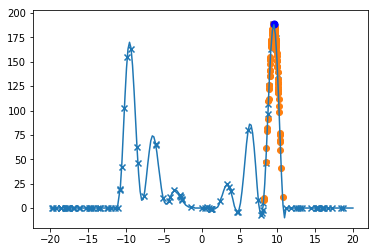

generation 99| best fitness 188.9709| best parents 9.5215
top parent 9.5215 top fitness 188.9709


In [74]:
parent_, fitness_, history_ = GA(init_pop, fitness)
print("top parent {} top fitness {}".format(parent_, fitness_))

# Applying genetic algorithms to Neural Networks

In [1]:
import numpy
import random

# Converting each solution from matrix to vector.
def mat_to_vector(mat_pop_weights):
    pop_weights_vector = []
    for sol_idx in range(mat_pop_weights.shape[0]):
        curr_vector = []
        for layer_idx in range(mat_pop_weights.shape[1]):
            vector_weights = numpy.reshape(mat_pop_weights[sol_idx, layer_idx], newshape=(mat_pop_weights[sol_idx, layer_idx].size))
            curr_vector.extend(vector_weights)
        pop_weights_vector.append(curr_vector)
    return numpy.array(pop_weights_vector)

# Converting each solution from vector to matrix.
def vector_to_mat(vector_pop_weights, mat_pop_weights):
    mat_weights = []
    for sol_idx in range(mat_pop_weights.shape[0]):
        start = 0
        end = 0
        for layer_idx in range(mat_pop_weights.shape[1]):
            end = end + mat_pop_weights[sol_idx, layer_idx].size
            curr_vector = vector_pop_weights[sol_idx, start:end]
            mat_layer_weights = numpy.reshape(curr_vector, newshape=(mat_pop_weights[sol_idx, layer_idx].shape))
            mat_weights.append(mat_layer_weights)
            start = end
    return numpy.reshape(mat_weights, newshape=mat_pop_weights.shape)

def select_mating_pool(pop, fitness, num_parents):
    # Selecting the best individuals in the current generation as parents for producing the offspring of the next generation.
    parents = numpy.empty((num_parents, pop.shape[1]))
    for parent_num in range(num_parents):
        max_fitness_idx = numpy.where(fitness == numpy.max(fitness))
        max_fitness_idx = max_fitness_idx[0][0]
        parents[parent_num, :] = pop[max_fitness_idx, :]
        fitness[max_fitness_idx] = -99999999999
    return parents

def crossover(parents, offspring_size):
    offspring = numpy.empty(offspring_size)
    # The point at which crossover takes place between two parents. Usually, it is at the center.
    crossover_point = numpy.uint32(offspring_size[1]/2)
    for k in range(offspring_size[0]):
        # Index of the first parent to mate.
        parent1_idx = k%parents.shape[0]
        # Index of the second parent to mate.
        parent2_idx = (k+1)%parents.shape[0]
        # The new offspring will have its first half of its genes taken from the first parent.
        offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        # The new offspring will have its second half of its genes taken from the second parent.
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
    return offspring


def mutation(offspring_crossover, mutation_percent):
    num_mutations = numpy.uint32((mutation_percent*offspring_crossover.shape[1])/100)
    mutation_indices = numpy.array(random.sample(range(0, offspring_crossover.shape[1]), num_mutations))
    # Mutation changes a single gene in each offspring randomly.
    for idx in range(offspring_crossover.shape[0]):
        # The random value to be added to the gene.
        random_value = numpy.random.uniform(-1.0, 1.0, 1)
        offspring_crossover[idx, mutation_indices] = offspring_crossover[idx, mutation_indices] + random_value
    return offspring_crossover

In [2]:
import numpy

def sigmoid(inpt):
    return 1.0 / (1.0 + numpy.exp(-1 * inpt))

def relu(inpt):
    result = inpt
    result[inpt < 0] = 0
    return result

def predict_outputs(weights_mat, data_inputs, data_outputs, activation="relu"):
    predictions = numpy.zeros(shape=(data_inputs.shape[0]))
    for sample_idx in range(data_inputs.shape[0]):
        r1 = data_inputs[sample_idx, :]
        for curr_weights in weights_mat:
            r1 = numpy.matmul(a=r1, b=curr_weights)
            if activation == "relu":
                r1 = relu(r1)
            elif activation == "sigmoid":
                r1 = sigmoid(r1)
        predicted_label = numpy.where(r1 == numpy.max(r1))[0][0]
        predictions[sample_idx] = predicted_label
    correct_predictions = numpy.where(predictions == data_outputs)[0].size
    accuracy = (correct_predictions / data_outputs.size) * 100
    return accuracy, predictions

def fitness(weights_mat, data_inputs, data_outputs, activation="relu"):
    accuracy = numpy.empty(shape=(weights_mat.shape[0]))
    for sol_idx in range(weights_mat.shape[0]):
        curr_sol_mat = weights_mat[sol_idx, :]
        accuracy[sol_idx], _ = predict_outputs(curr_sol_mat, data_inputs, data_outputs, activation=activation)
    return accuracy

In [4]:
!pwd

/Users/jinpark/Documents/GA/NeuralGenetic/Tutorial Project


In [5]:
import numpy
import GA
import pickle
import ANN
import matplotlib.pyplot

f = open("dataset_features.pkl", "rb")
data_inputs2 = pickle.load(f)
f.close()
features_STDs = numpy.std(a=data_inputs2, axis=0)
data_inputs = data_inputs2[:, features_STDs>50]


f = open("outputs.pkl", "rb")
data_outputs = pickle.load(f)
f.close()

#Genetic algorithm parameters:
#    Mating Pool Size (Number of Parents)
#    Population Size
#    Number of Generations
#    Mutation Percent

sol_per_pop = 8
num_parents_mating = 4
num_generations = 1000
mutation_percent = 10

#Creating the initial population.
initial_pop_weights = []
for curr_sol in numpy.arange(0, sol_per_pop):
    HL1_neurons = 150
    input_HL1_weights = numpy.random.uniform(low=-0.1, high=0.1, 
                                             size=(data_inputs.shape[1], HL1_neurons))

    HL2_neurons = 60
    HL1_HL2_weights = numpy.random.uniform(low=-0.1, high=0.1, 
                                             size=(HL1_neurons, HL2_neurons))

    output_neurons = 4
    HL2_output_weights = numpy.random.uniform(low=-0.1, high=0.1, 
                                              size=(HL2_neurons, output_neurons))

    initial_pop_weights.append(numpy.array([input_HL1_weights, 
                                                HL1_HL2_weights, 
                                                HL2_output_weights]))

pop_weights_mat = numpy.array(initial_pop_weights)
pop_weights_vector = ga.mat_to_vector(pop_weights_mat)

best_outputs = []
accuracies = numpy.empty(shape=(num_generations))

for generation in range(num_generations):
    print("Generation : ", generation)

    # converting the solutions from being vectors to matrices.
    pop_weights_mat = ga.vector_to_mat(pop_weights_vector, 
                                       pop_weights_mat)

    # Measuring the fitness of each chromosome in the population.
    fitness = ANN.fitness(pop_weights_mat, 
                          data_inputs, 
                          data_outputs, 
                          activation="sigmoid")

    accuracies[generation] = fitness[0]
    print("Fitness")
    print(fitness)

    # Selecting the best parents in the population for mating.
    parents = ga.select_mating_pool(pop_weights_vector, 
                                    fitness.copy(), 
                                    num_parents_mating)
    print("Parents")
    print(parents)

    # Generating next generation using crossover.
    offspring_crossover = ga.crossover(parents,
    offspring_size=(pop_weights_vector.shape[0]-parents.shape[0], pop_weights_vector.shape[1]))

    print("Crossover")
    print(offspring_crossover)

    # Adding some variations to the offsrping using mutation.
    offspring_mutation = ga.mutation(offspring_crossover, mutation_percent=mutation_percent)
    print("Mutation")
    print(offspring_mutation)

    # Creating the new population based on the parents and offspring.
    pop_weights_vector[0:parents.shape[0], :] = parents
    pop_weights_vector[parents.shape[0]:, :] = offspring_mutation

pop_weights_mat = ga.vector_to_mat(pop_weights_vector, pop_weights_mat)
best_weights = pop_weights_mat [0, :]
acc, predictions = ANN.predict_outputs(best_weights, data_inputs, data_outputs, activation="sigmoid")
print("Accuracy of the best solution is : ", acc)

matplotlib.pyplot.plot(accuracies, linewidth=5, color="black")
matplotlib.pyplot.xlabel("Iteration", fontsize=20)
matplotlib.pyplot.ylabel("Fitness", fontsize=20)
matplotlib.pyplot.xticks(numpy.arange(0, num_generations+1, 100), fontsize=15)
matplotlib.pyplot.yticks(numpy.arange(0, 101, 5), fontsize=15)

f = open("weights_"+str(num_generations)+"_iterations_"+str(mutation_percent)+"%_mutation.pkl", "wb")
pickle.dump(pop_weights_mat, f)
f.close()

ImportError: cannot import name 'GA'